## Image Captioning Process

1. Imafe feature extraction
    - Load the images from the directory `FLickr8k_Dataset`
    - make a prediction using VGG16 model to extract the only features and not the classification task that is done by VGG16.
      
      `Explanation` : VGG16 is image classification model, it gives probability distribution of object in image. SO by removing the last Classification head layer, we end with second last layer that holds the logits/features that are used by last layer to classify the objects. We store these `features` in the `feature.pkl` file.

      `Advice` :  Go look for other image related models like ResNet, MobiNet, YOLO and identify theier main function for image(classification, object detection, recognition, etc) try to think to use them.
2. Text feature extraction
    
      - Load the Caption.txt file that holds **image_id** and **caption** for image. Parse them into dictionary {image_id:caption} by removing the image extenions.
      - `Preprocess` the `captions` in dictionary by removing stopwords, punctuations, numerics, special charaters.
      - `Make a vocabulary` form the captions for later use in modeling the captions.
3. Captions Modeling

      - Tokenize the captions to feed into the RNN model, which will generate the embeddings.
      - Pad the sequences.
      - LSTM model

4.

In [7]:
image_caption = '/content/drive/MyDrive/Image_caption'

In [8]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
Flicker_dataset = os.path.join(image_caption,'Flickr8k_Dataset')

In [9]:
import os
import re ,string
import numpy as np

In [ ]:
def load_doc(filename):
# open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
            # store description
            mapping[image_id].append(image_desc)
    return mapping


In [ ]:
def clean_descriptions(descriptions):
# prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [re_punc.sub('', w) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] = ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
# build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    # save descriptions

In [ ]:
filename = os.path.join(image_caption,'captions.txt')
# load description
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, os.path.join(image_caption,'descriptions.txt'))


Loaded: 8092 
Vocabulary Size: 4454


Did Preprocessed the Caption and Photo feature extraction

## Load the image feature and caption preprocessed data

In [10]:

from numpy import array
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.callbacks import ModelCheckpoint

In [11]:
#import tokenizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
from pickle import load
# load doc into memory
def load_doc(filename):
# open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
    # skip empty lines
        if len(line) < 1:
            continue
    # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


#### Extract Features of image and text

In [13]:

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
        # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
# load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [14]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
# prepare tokenizer

# tokenizer = create_tokenizer(train_descriptions)
# vocab_size = len(tokenizer.word_index) + 1
# print('Vocabulary Size: %d' % vocab_size)


#### Create word-by-word Text model


In [24]:
def max_length_cal(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)



# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
        # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length,padding='post')[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)


In [16]:
max_length

NameError: name 'max_length' is not defined

In [17]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(1000,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [18]:
# load training dataset (6K)
filename = ('Flickr_8k_trainImages.txt')
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))



Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [19]:
len(train_features['2318659263_c24005a5cb'][0]),train_features['2318659263_c24005a5cb'].shape, len(train_features)

(1000, (1, 1000), 6000)

In [ ]:
train_features.keys()

dict_keys(['2188688248_f57a28a5a7', '2799871904_3b3125518a', '2653552905_4301449235', '2650485780_29d89268d7', '391723162_3bdeb7ea33', '3429581486_4556471d1a', '367925122_335ed279a8', '3331900249_5872e90b25', '55473406_1d2271c1f2', '487894806_352d9b5e66', '811663364_4b350a62ce', '2902661518_1513be3ea6', '3351370405_e417e38f52', '3708244207_0d3a2b2f92', '44856031_0d82c2c7d1', '3744832122_2f4febdff6', '3181322965_ce9da15271', '437404867_209625774d', '1884727806_d84f209868', '3421177332_a05741cfa4', '975131015_9acd25db9c', '3668984985_b60ceb2ae9', '2266142543_b2de18c081', '3033741581_136889ac73', '2256320794_0286c31bfa', '3025513877_1a6160070d', '2629027962_9cc3b46527', '3029463004_c2d2c8f404', '3677514746_26f5588150', '3288274849_07ff76ee93', '839295615_bb9baf2f95', '3656151153_b4ed5d94c4', '1222322358_225067636e', '223299137_b0e81ac145', '3093971101_543237971d', '3409740108_1505489537', '2952751562_ff1c138286', '2973272684_4d63cbc241', '693450725_8ad72389e6', '3034585889_388d6ffcc0', '3

In [ ]:
train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq'],
 '1003163366_44323f5815': ['startseq man lays on bench while his dog sits by him endseq'],
 '1007129816_e794419615': ['startseq man in an orange hat starring at something endseq'],
 '1007320043_627395c3d8': ['startseq child playing on rope net endseq'],
 '1009434119_febe49276a': ['startseq black and white dog is running in grassy garden surrounded by white fence endseq'],
 '1012212859_01547e3f17': ['startseq dog shakes its head near the shore red ball next to it endseq'],
 '1015118661_980735411b': ['startseq boy smiles in front of stony wall in city endseq'],
 '1015584366_dfcec3c85a': ['startseq black dog leaps over log endseq'],
 '101654506_8eb26cfb60': ['start

In [25]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length_cal(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions,
train_features)

Vocabulary Size: 3831
Description Length: 30


In [ ]:
#phots          padded/input words   next word to be predicted.
#one photo is associated with 30-words
X1train.shape , X2train.shape, ytrain.shape

((60537, 1000), (60537, 30), (60537, 3831))

In [ ]:
X1train, X2train,ytrain

(array([[6.5925674e-06, 2.2863829e-05, 4.8247157e-06, ..., 2.5610643e-05,
         1.2180602e-04, 3.6955906e-05],
        [6.5925674e-06, 2.2863829e-05, 4.8247157e-06, ..., 2.5610643e-05,
         1.2180602e-04, 3.6955906e-05],
        [6.5925674e-06, 2.2863829e-05, 4.8247157e-06, ..., 2.5610643e-05,
         1.2180602e-04, 3.6955906e-05],
        ...,
        [2.1052497e-08, 2.1417047e-06, 1.4036571e-07, ..., 4.4708082e-07,
         6.2675088e-07, 9.2591719e-05],
        [2.1052497e-08, 2.1417047e-06, 1.4036571e-07, ..., 4.4708082e-07,
         6.2675088e-07, 9.2591719e-05],
        [2.1052497e-08, 2.1417047e-06, 1.4036571e-07, ..., 4.4708082e-07,
         6.2675088e-07, 9.2591719e-05]], dtype=float32),
 array([[   0,    0,    0, ...,    0,    0,    1],
        [   0,    0,    0, ...,    0,    1,   38],
        [   0,    0,    0, ...,    1,   38,    3],
        ...,
        [   0,    0,    0, ...,   60,   74,   71],
        [   0,    0,    0, ...,   74,   71,  455],
        [   0,    

In [26]:
# load test set
filename = ('Flickr_8k_devImages.txt')
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions,
                                            test_features)


Dataset: 1000
Descriptions: test=1000
Photos: test=1000


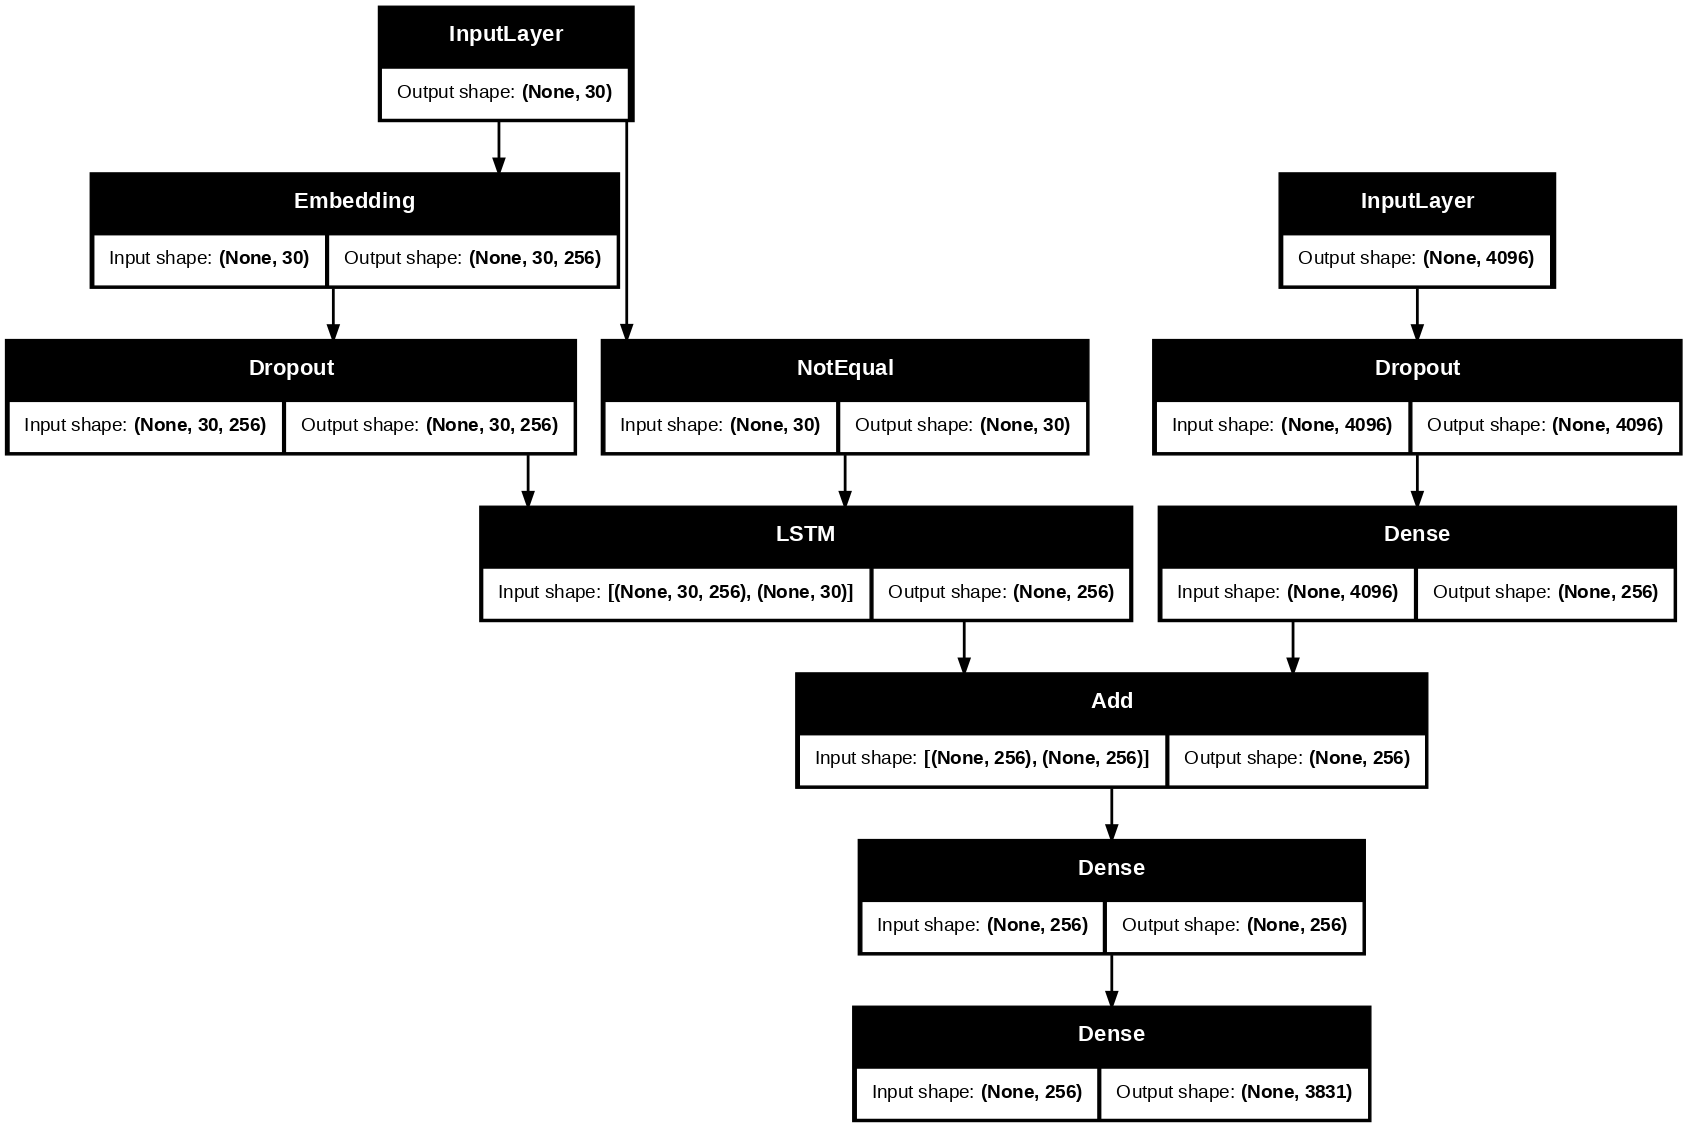

In [ ]:
plot_model(model,dpi=100, show_shapes=True)

In [27]:
# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
checkpoint = ModelCheckpoint('image_caption.keras', monitor='val_loss', verbose=1,
save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint],
validation_data=([X1test, X2test], ytest))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 30, 256)        │        980,736 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1000)           │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 30, 256)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 30)             │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        256,256 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ dropout_5[0][0],       │
│                           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256)            │              0 │ dense_6[0][0],         │
│                           │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │         65,792 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 3831)           │        984,567 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,812,663 (10.73 MB)

 Trainable params: 2,812,663 (10.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 4.46712, saving model to image_caption.keras
1892/1892 - 19s - 10ms/step - loss: 5.0729 - val_loss: 4.4671
Epoch 2/20

Epoch 2: val_loss improved from 4.46712 to 4.15907, saving model to image_caption.keras
1892/1892 - 14s - 7ms/step - loss: 4.2786 - val_loss: 4.1591
Epoch 3/20

Epoch 3: val_loss improved from 4.15907 to 4.05347, saving model to image_caption.keras
1892/1892 - 21s - 11ms/step - loss: 3.9223 - val_loss: 4.0535
Epoch 4/20

Epoch 4: val_loss improved from 4.05347 to 4.02558, saving model to image_caption.keras
1892/1892 - 20s - 11ms/step - loss: 3.6698 - val_loss: 4.0256
Epoch 5/20

Epoch 5: val_loss did not improve from 4.02558
1892/1892 - 14s - 7ms/step - loss: 3.4658 - val_loss: 4.0773
Epoch 6/20

Epoch 6: val_loss did not improve from 4.02558
1892/1892 - 21s - 11ms/step - loss: 3.2847 - val_loss: 4.1286
Epoch 7/20

Epoch 7: val_loss did not improve from 4.02558
1892/1892 - 14s - 7ms/step - loss: 3.1171 - val_loss: 4.2

In [28]:
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from numpy import argmax
from pickle import load

In [39]:
# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
  # seed the generation process
  in_text = 'startseq'
  # iterate over the whole length of the sequence
  for _ in range(max_length):
    # integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad input
    sequence = pad_sequences([sequence], maxlen=max_length,padding='post')
    # predict next word
    yhat = model.predict([photo,sequence], verbose=0)
    # convert probability to integer
    yhat = argmax(yhat)
    # map integer to word
    word = word_for_id(yhat, tokenizer)
    # stop if we cannot map the word
    if word is None:
       break
    # append as input for generating the next word
    in_text += ' ' + word
    # stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text

# remove start/end sequence tokens from a summary
def cleanup_summary(summary):
  # remove start of sequence token
  index = summary.find('startseq ')
  if index > -1:
    summary = summary[len('startseq '):]
  # remove end of sequence token
  index = summary.find(' endseq')
  if index > -1:
    summary = summary[:index]
  return summary

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
  actual, predicted = list(), list()
  # step over the whole set
  for key, desc_list in descriptions.items():
  # generate description
    yhat = generate_desc(model, tokenizer, photos[key], max_length)
  # clean up prediction
    yhat = cleanup_summary(yhat)
  # store actual and predicted
    references = [cleanup_summary(d).split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


In [35]:
#load training dataset (6K)
filename = 'Flickr_8k_trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length_cal(train_descriptions)
print('Description Length: %d' % max_length)
# load test set
filename = 'Flickr_8k_testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))


Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 3831
Description Length: 30
Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [40]:
filename = 'image_caption.keras'
model_loaded = load_model(filename)
# evaluate model
evaluate_model(model_loaded, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.208238
BLEU-2: 0.101331
BLEU-3: 0.073010
BLEU-4: 0.032088


### Using the model..

In [42]:
from pickle import dump
# load training dataset
filename = 'Flickr_8k_trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [50]:
 len(tokenizer.word_index)

3830

In [53]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# extract features from each photo in the directory
def extract_features(filename):
  # load the model
  model = VGG16()
  # re-structure the model
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  # load the photo
  image = load_img(filename, target_size=(224, 224))
  # convert the image pixels to a numpy array
  image = img_to_array(image)
  # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # prepare the image for the VGG model
  image = preprocess_input(image)
  # get features
  feature = model.predict(image, verbose=0)
  return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None


In [55]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 30
# load the model
model = load_model('image_caption.keras')
# load and prepare the photograph
photo = extract_features('R_4.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
description = cleanup_summary(description)
print(description)


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step
boy in red shirt is standing on the camera


In [56]:
photo = extract_features('cat.jpg')
predi2 = generate_desc(model, tokenizer, photo, max_length)
predi2 = cleanup_summary(predi2)
print(predi2)

man in red shirt is standing on the beach


In [59]:
p = extract_features('beach.jpg')
predi3 = generate_desc(model, tokenizer, p, max_length)
predi3 = cleanup_summary(predi2)
print(predi3)

man in red shirt is standing on the beach


In [ ]:
import tensorflow
tensorflow.__version__


'2.17.0'

train_discriptions=> img_id : captions

train_features    => img_id : img_features

X1_img , X2_word = y_next_word


In [ ]:
from sklearn.feature_extraction.text import  TfidfVectorizer